**<h1>This notebook is under the purpose of predicting the Rarity of certain Objects <br> approaching the Earth using: <br><span style ="color: green;"> The NEO Earth Close Approaches Dataset From NASA </span></h1>**

This is a classification problem, and next explains the process!

**<h2 style = "color:#FFDB5C;">1/ Importing the necessary Libraries<h2>**

In [181]:
#Libraries for data manipulation and visualization
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Libraries for data preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#Libraries for model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#Libraries for model evaluation
from sklearn.metrics import accuracy_score, classification_report


**<h2 style = "color:#FFDB5C;">2/ Data Preprocessing<h2>**

In [182]:
#uploading the dataset
df = pd.read_csv('NEO Earth Close Approaches.csv')
#displaying the first 5 rows of the dataset
df.head()

,Object,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity
0,(2023 JA1),2023-May-03 01:15 ± < 00:01,0.02518,0.02509,5.01,4.99,26.6,13 m - 29 m,0
1,(2023 HV5),2023-May-03 03:16 ± < 00:01,0.00291,0.00290,8.93,8.82,27.2,9.8 m - 22 m,0
2,(2023 JM2),2023-May-03 05:23 ± < 00:01,0.04008,0.03996,6.33,6.32,26.0,17 m - 38 m,0
3,(2023 HF7),2023-May-04 00:02 ± < 00:01,0.00427,0.00426,13.10,13.05,26.8,12 m - 26 m,0
4,(2023 HH7),2023-May-04 05:47 ± < 00:01,0.00561,0.00558,24.55,24.53,25.5,21 m - 47 m,1


**Let's get an idea about what do these columns mean**
**About Dataset**
Near-Earth Objects (NEOs) are a category of asteroids whose orbits come close to intersecting Earth’s orbit. These objects are tracked carefully by astronomers due to their potential impact risk with our planet. As they orbit the Sun, NEOs occasionally approach close to Earth.

NASA’s Center for Near-Earth Object Studies (CNEOS) calculates the motion of all NEOs forwards to 2200 A.D. and backwards to 1900 A.D., determining the times and distances of Earth close approaches.

_Object:_

Object primary designation

**Data Description (Variables):**

_Close-Approach (CA) Date_

Date and time (TDB) of closest Earth approach. "Nominal Date" is given to appropriate precision. The 3-sigma uncertainty in the time is given in the +/- column in days_hours:minutes format (for example, "2_15:23" is 2 days, 15 hours, 23 minutes; "< 00:01" is less than 1 minute).

_CA Distance Nominal (au)_

The most likely (Nominal) close-approach distance (Earth center to NEO center), in astronomical units.

_CA Distance Minimum (au)_

The minimum possible close-approach distance (Earth center to NEO center), in astronomical units. The minimum possible distance is based on the 3-sigma Earth target-plane error ellipse.

_V relative (km/s)_

Object velocity relative to Earth at close-approach.

_V infinity (km/s)_

Object velocity relative to a massless Earth at close-approach.

_H (mag)_

Asteroid absolute magnitude (in general, smaller H implies larger asteroid diameter). Undefined for comets.

_Diameter_

Diameter value when known or a range (min - max) estimated using the asteroid's absolute magnitude (H) and limiting albedos of 0.25 and 0.05.

_Rarity_

A measure of how infrequent the Earth close approach is for asteroids of the same size and larger: 0 means an average frequency of 100 per year, i.e., roughly every few days or less, 1 corresponds to roughly once a month, 2 to roughly once a year, 3 to roughly once a decade, etc. 'n/a' means that a frequency estimate is not available.


In [183]:
#looking in the columns types to see if there any type of transformation we need to make
df.dtypes

Object                       object
Close-Approach (CA) Date     object
CA DistanceNominal (au)     float64
CA DistanceMinimum (au)     float64
V relative(km/s)            float64
V infinity(km/s)            float64
H(mag)                      float64
Diameter                     object
Rarity                        int64
dtype: object

We notice that the columns _Object_, _Close-Approach (CA) Date_ and _Diameter_ are under the type object which will cause problems with our model training and evaluation.

In [184]:
#We take care of the column Object since it is for identification only and doesn't add any necessary value
#to the process whatsoever
df = df.drop('Object', axis=1)

We deal with the first column Close-Approach (CA) Date

In [185]:
#first we make it a string
df['Close-Approach (CA) Date'] = df['Close-Approach (CA) Date'].astype(str)
#we split the string so we can get rid of the time since its affect on spacial movement is very negligible
df['Close-Approach (CA) Date'] = df['Close-Approach (CA) Date'].str.split(' ').str[0]
#we convert the string to a datetime keeping the year only
df['Close-Approach (CA) Date'] = pd.to_datetime(df['Close-Approach (CA) Date']).dt.year
#this leads us to only keeping the necessary available years 2023 and 2024

We move to the Diameter Column that is an object under a range of format
We are going to try and convert it into an integer/float that represents the mean of the two interval available values, this way we can use it in training more effectively and we can carry on with the preprocessing efficiently as well

In [186]:
for index, row in df.iterrows():
    #Split the diameter string into two parts
    diameter_parts = row['Diameter'].split(' - ')
    if len(diameter_parts) == 2:
        #Extract the first part of the diameter string and remove 'km' or 'm'
        first_value_str = diameter_parts[0].strip(' km').strip(' m')
        #Extract the second part of the diameter string and remove 'km' or 'm'
        second_value_str = diameter_parts[1].strip(' km').strip(' m')
        #Convert the string values to float
        first_value = float(first_value_str)
        second_value = float(second_value_str)
        #Calculate the mean and assign it to a new column
        df.at[index, 'Mean Diameter'] = (first_value + second_value) / 2
    else:
        #Handle cases where the diameter format is unexpected
        df.at[index, 'Mean Diameter'] = None

In [187]:
#we delete the diameter column since we no longer need it, 
#and we replaced it with the mean diameter column
df = df.drop('Diameter', axis=1)

Here we can see the result of this data transformation process

In [188]:
df.head()

,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Rarity,Mean Diameter
0,2023,0.02518,0.02509,5.01,4.99,26.6,0,21.0
1,2023,0.00291,0.00290,8.93,8.82,27.2,0,15.9
2,2023,0.04008,0.03996,6.33,6.32,26.0,0,27.5
3,2023,0.00427,0.00426,13.10,13.05,26.8,0,19.0
4,2023,0.00561,0.00558,24.55,24.53,25.5,1,34.0


In [189]:
df.dtypes

Close-Approach (CA) Date      int64
CA DistanceNominal (au)     float64
CA DistanceMinimum (au)     float64
V relative(km/s)            float64
V infinity(km/s)            float64
H(mag)                      float64
Rarity                        int64
Mean Diameter               float64
dtype: object

Now that all of our data is under one type, we can proceed to the next step

<h3>Checking for missing/null values</h3>

In [190]:
df.isnull().sum()

Close-Approach (CA) Date    0
CA DistanceNominal (au)     0
CA DistanceMinimum (au)     0
V relative(km/s)            0
V infinity(km/s)            0
H(mag)                      0
Rarity                      0
Mean Diameter               3
dtype: int64

Since only three values are missing we replace with the mean as a data imputation method

In [191]:
df['Mean Diameter'] = df['Mean Diameter'].fillna(df['Mean Diameter'].mean())

We check for columns with only one unique value because that would they are contributing whatsoever to the dataset

In [192]:
df.nunique()
#no need to drop any extra columns

Close-Approach (CA) Date       2
CA DistanceNominal (au)     1342
CA DistanceMinimum (au)     1322
V relative(km/s)            1025
V infinity(km/s)            1036
H(mag)                       116
Rarity                         4
Mean Diameter                280
dtype: int64

**<h2>visualizations</h2>**

In [193]:
sns.set_theme(style='darkgrid')

sns.set_palette('muted')


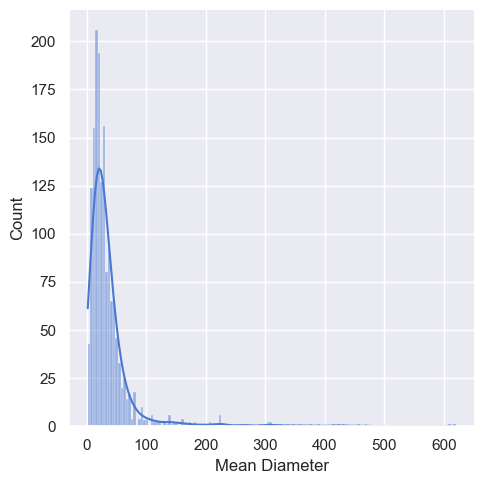

In [194]:
sns.displot(df['Mean Diameter'], kde=True);

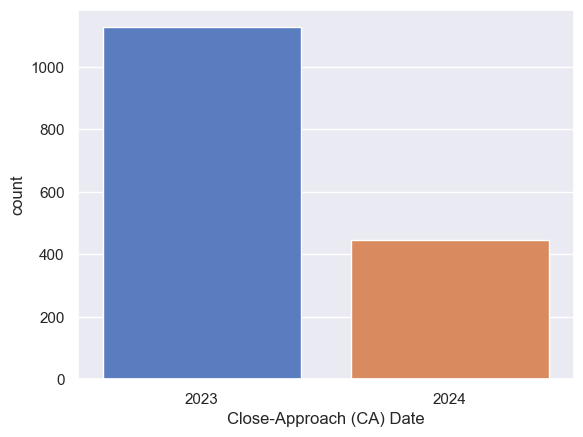

In [195]:
sns.countplot(x='Close-Approach (CA) Date', data=df);

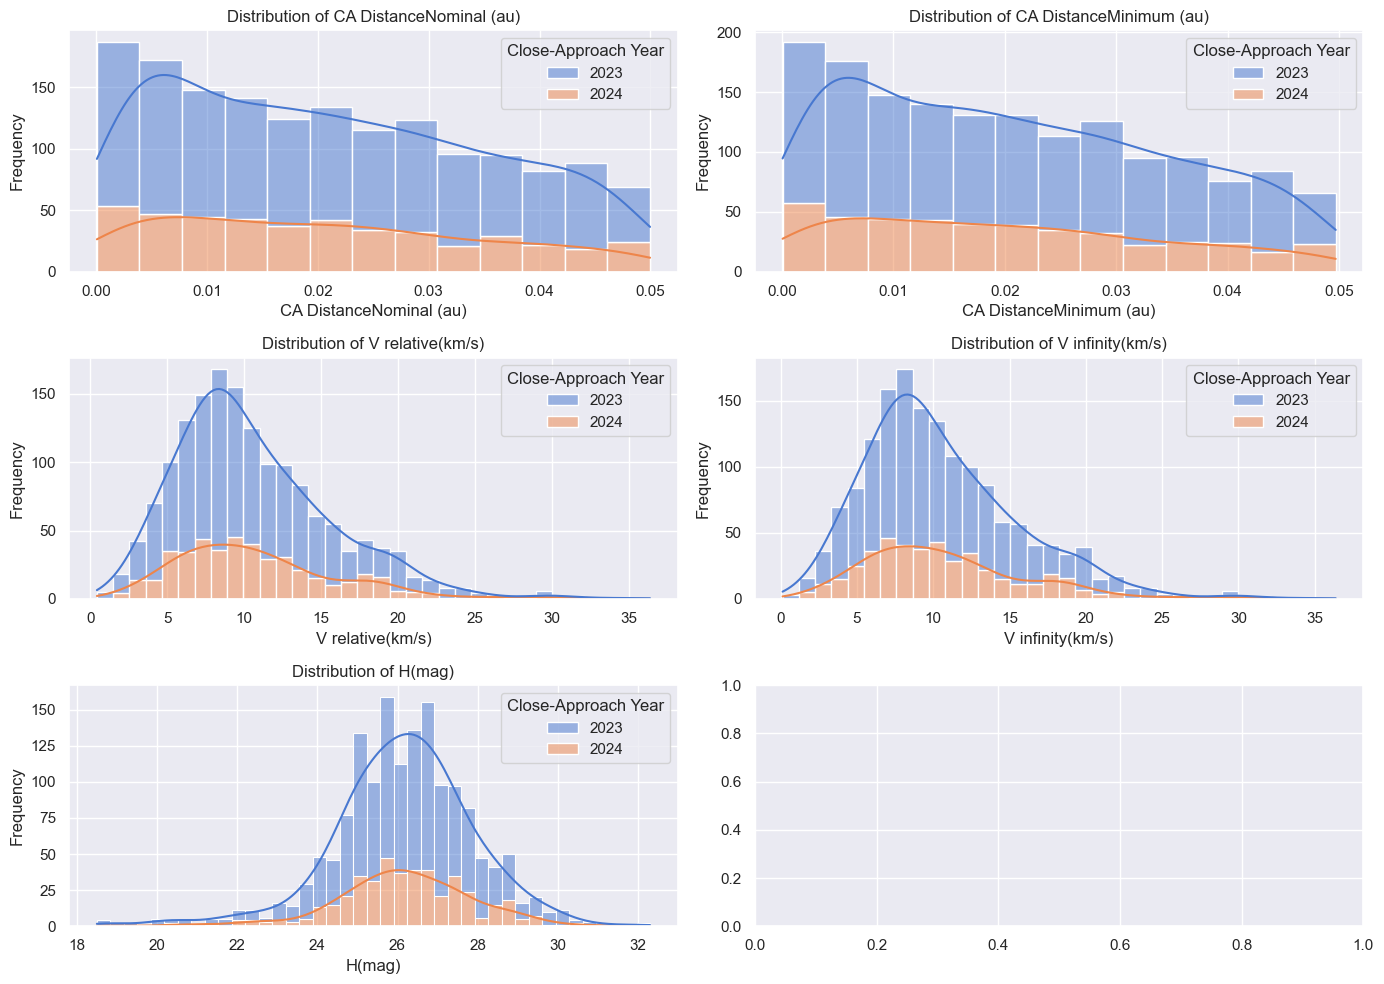

In [223]:
# List of columns to plot
columns = ['CA DistanceNominal (au)', 'CA DistanceMinimum (au)', 'V relative(km/s)', 'V infinity(km/s)','H(mag)']

# Create a 2x2 grid of plots
fig, axs = plt.subplots(3, 2, figsize=(14, 10))

# Flatten the axes array for easy iteration
axs = axs.flatten()
# Extract year from 'Close-Approach (CA) Date' and create a new column
df['Close-Approach Year'] = df['Close-Approach (CA) Date'].astype('category')

# Plot each distribution in the grid
for i, column in enumerate(columns):
    sns.histplot(data=df, x=column, ax=axs[i],kde=True, hue='Close-Approach Year', multiple='stack')
    axs[i].set_title(f'Distribution of {column}')
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

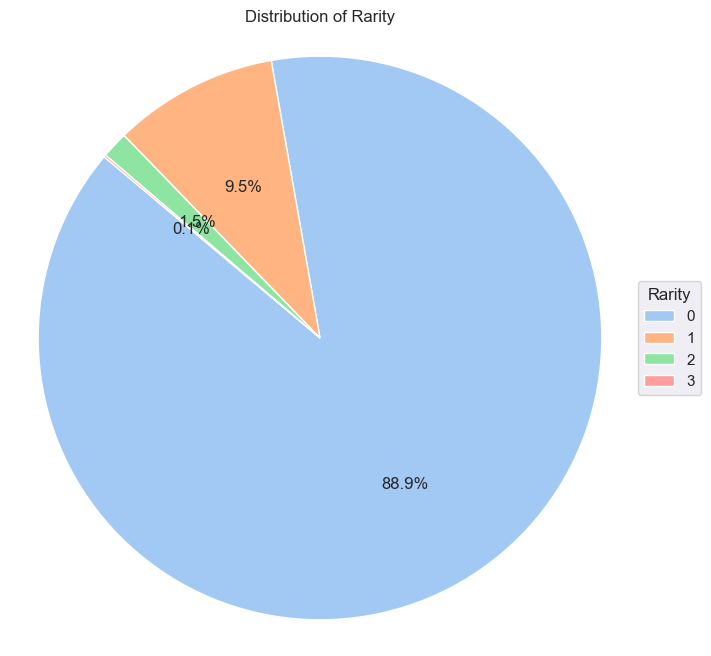

In [214]:
# Calculate counts for 'Rarity'
rarity_counts = df['Rarity'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 8))
wedges, texts, autotexts=plt.pie(rarity_counts, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel', len(rarity_counts)))
# Add a legend
plt.legend(wedges, rarity_counts.index, title="Rarity", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1));
# Customize the plot
plt.title('Distribution of Rarity')
plt.axis('equal');

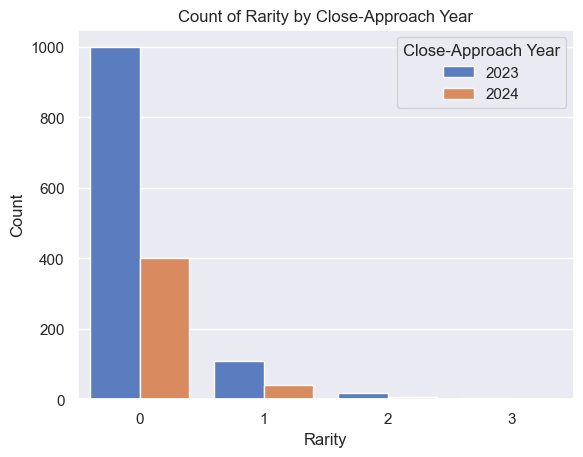

In [226]:
sns.countplot(x='Rarity', data=df,hue='Close-Approach Year')
plt.xlabel('Rarity')
plt.ylabel('Count')
plt.title('Count of Rarity by Close-Approach Year');

<h3>Handling outliers</h3>
outliers can really affect the direction our data is biased to, therefore detecting them would give amazing outcome, there many ways to figure out that we first start by plotting the box plots of the numerical columns

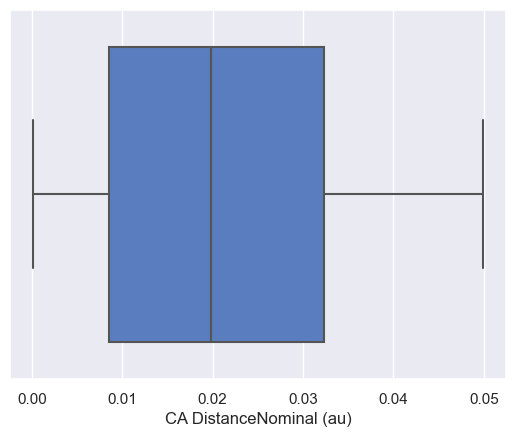

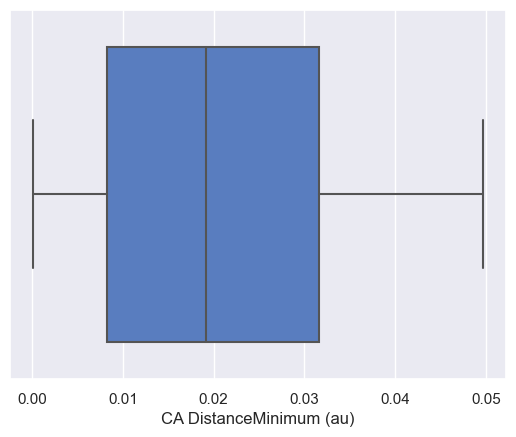

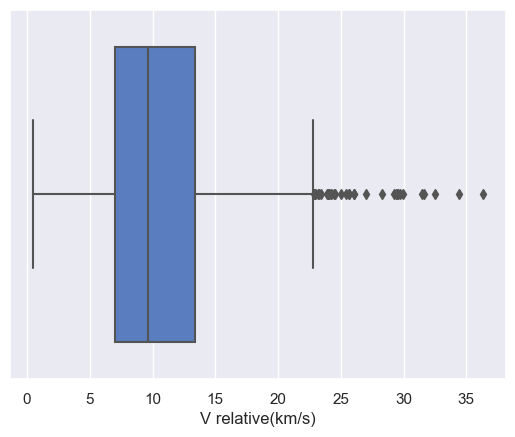

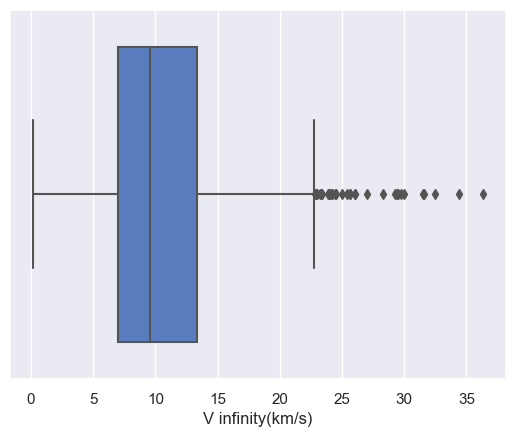

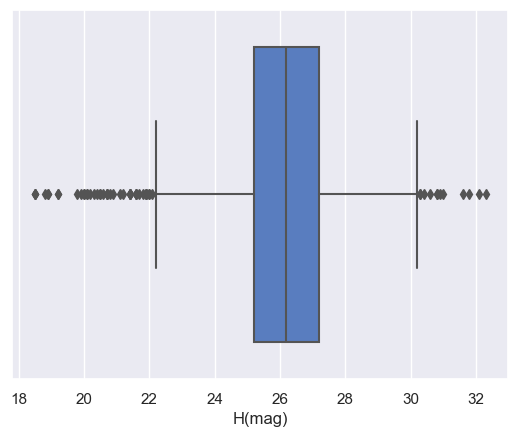

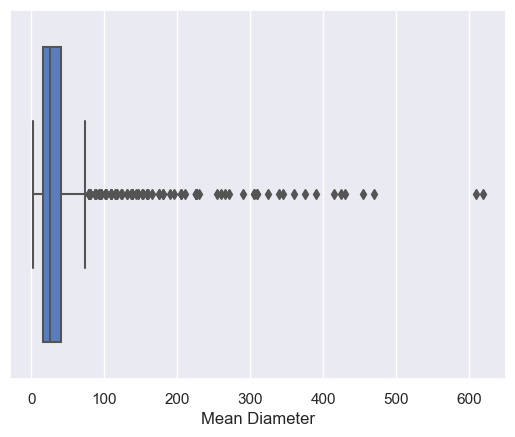

In [198]:
numerical_columns = [
    'CA DistanceNominal (au)',
    'CA DistanceMinimum (au)',
    'V relative(km/s)',
    'V infinity(km/s)',
    'H(mag)',
    'Mean Diameter',
]
#Rarity is not considered since it is the target variable with only four options
for column in numerical_columns:
    sns.boxplot(x=column, data=df)
    plt.show()

According to box plots, the points outside the whiskers generally stand for outliers, <br>however we cant be sure of that since the situation here concerns space related data which implies many extraordinary events in addition to measurements mistakes

**<h3>We go for a further analysis by using <span style="color:red;">Z_Score method </span><br>to validate the sanity of our reasoning</h3>**

In [199]:
for column in numerical_columns:
    mean = df[column].mean()
    std_dev = df[column].std()
    df[f'{column} Z-score'] = (df[column] - mean) / std_dev
    df[f'{column} Outlier'] = np.abs(df[f'{column} Z-score']) > 3

record_df = df.copy()
for column in numerical_columns:
    outliers = record_df[record_df[f'{column} Outlier']]
    print(f"\nIdentified Outliers in {column}:")
    print(outliers[[column, f'{column} Z-score']])

#We save the results to a new CSV file to facilitate the manipulation later
record_df.to_csv('outliers_detected.csv', index=False)


Identified Outliers in CA DistanceNominal (au):
Empty DataFrame
Columns: [CA DistanceNominal (au), CA DistanceNominal (au) Z-score]
Index: []

Identified Outliers in CA DistanceMinimum (au):
Empty DataFrame
Columns: [CA DistanceMinimum (au), CA DistanceMinimum (au) Z-score]
Index: []

Identified Outliers in V relative(km/s):
      V relative(km/s)  V relative(km/s) Z-score
374              29.74                  3.754436
519              36.37                  5.054740
612              34.44                  4.676221
637              29.53                  3.713250
780              29.97                  3.799545
1084             31.49                  4.097654
1213             31.60                  4.119228
1220             27.02                  3.220978
1231             26.02                  3.024854
1273             29.42                  3.691677
1321             26.08                  3.036621
1351             32.50                  4.295739
1432             28.30             

In [200]:
#we read the csv created for us to get some idea on it
outliers = pd.read_csv('outliers_detected.csv')
for column in numerical_columns:
    print(df[f'{column} Outlier'].value_counts())


False    1573
Name: CA DistanceNominal (au) Outlier, dtype: int64
False    1573
Name: CA DistanceMinimum (au) Outlier, dtype: int64
False    1558
True       15
Name: V relative(km/s) Outlier, dtype: int64
False    1558
True       15
Name: V infinity(km/s) Outlier, dtype: int64
False    1546
True       27
Name: H(mag) Outlier, dtype: int64
False    1539
True       34
Name: Mean Diameter Outlier, dtype: int64


False values are normal values, however True ones according to the Z_score refer to the outliers, <br> further we calculate the the global rate of these outliers, and it doesn't exceed <span style = "color:red;"> 5% </span>then outliers can be considered <br>as normal rare behavior and there is no need to delete them or impute them

In [201]:
for column in numerical_columns:
    outlier_column = f'{column} Outlier'
    if outlier_column in outliers.columns:
        true_count = outliers[outlier_column].value_counts().get(True, 0)
        total_count = len(outliers[outlier_column])
        true_percentage = (true_count / total_count) * 100
        print(f"{outlier_column}: {true_percentage:.2f}% True values")

CA DistanceNominal (au) Outlier: 0.00% True values
CA DistanceMinimum (au) Outlier: 0.00% True values
V relative(km/s) Outlier: 0.95% True values
V infinity(km/s) Outlier: 0.95% True values
H(mag) Outlier: 1.72% True values
Mean Diameter Outlier: 2.16% True values


**<h3>Lucky us!, the highest pourcentage of outliers is only <span style = "color:green;"> 2.16% which is way under 5% </span>,<br> which means there is no need for us to proceed with the outliers detection and procedure</h3>**

**<h3>Normalizing the  'Mean Diameter' column </h3>**

In [202]:
df['Mean Diameter Normalized'] = (df['Mean Diameter'] - df['Mean Diameter'].mean()) / df['Mean Diameter'].std()

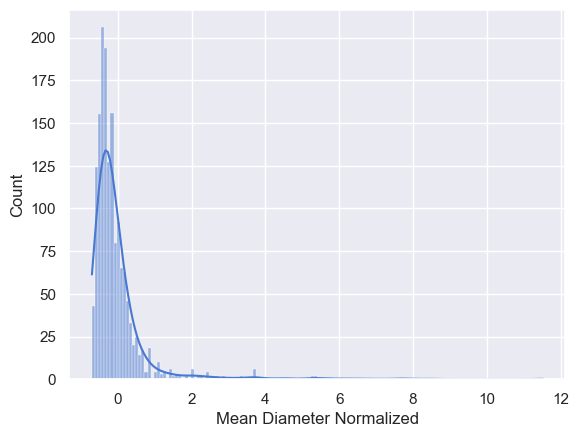

In [203]:
sns.histplot(df['Mean Diameter Normalized'], kde=True );

**<h3>Now Moving to an important issue with our dataset which is Imbalance</h3>**

In [204]:
df['Rarity'].value_counts()

0    1399
1     149
2      24
3       1
Name: Rarity, dtype: int64

as displayed above, there an incredible imbalance in our target variable that is going to affect very much our results and model prediction ability

Since the dataset is relatively small, using oversampling to deal with the imbalance would lead to stupidly duplicating rows, <br>however by using **<span style="color:green;"> SMOTE method</span>**,<br> we can skip variety of problems because it generates synthetic data which is considered to be more reliable in our case <br>without the excessive huge increase oversampling would be causing.

The SMOTE method works by calculating the distances to generate the data,<br> therefore we would to duplicate the column with the Rarity 3 only once because SMOTE method needs at least two neighbors to be applied

In [205]:
condition = (df['Rarity'] == 3)
row_to_duplicate = df.loc[condition].iloc[0] 
duplicated_row = row_to_duplicate.copy() 
df = df.append(duplicated_row, ignore_index=True)
df['Rarity'].value_counts()

C:\Users\boume\AppData\Local\Temp\ipykernel_24016\917823707.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(duplicated_row, ignore_index=True)


0    1399
1     149
2      24
3       2
Name: Rarity, dtype: int64

Now that it's all done, we move to the SMOTE method

In [206]:
from imblearn.over_sampling import SMOTE
X = df.drop('Rarity', axis=1)  
y = df['Rarity']
smote = SMOTE(sampling_strategy='auto', k_neighbors=1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [207]:
y_resampled.value_counts()

0    1399
1    1399
2    1399
3    1399
Name: Rarity, dtype: int64

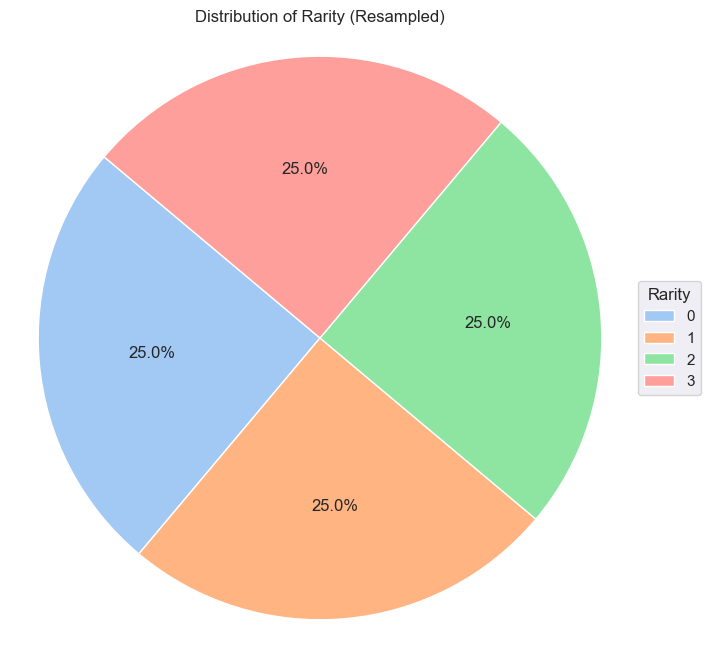

In [219]:
rarity_counts_resampled = y_resampled.value_counts()

# Create the pie chart
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(rarity_counts_resampled,  autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel', len(rarity_counts_resampled)))

# Customize the plot
plt.title('Distribution of Rarity (Resampled)')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

# Add a legend
plt.legend(wedges, rarity_counts_resampled.index, title="Rarity", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))


Now all target variations have equal training chances

**<h3>We split and standardize the data so we could start the model building phase</h3>**

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**<h2 style = "color:#FFDB5C;">3/ Model Building<h2>**

We are going to test a bunch of classification model to see which ones perform best and try and give an analysis to why they are suitable to this dataset

In [209]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Machine': SVC(),
    'k-Nearest Neighbors': KNeighborsClassifier()
}
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    results[name] = {'accuracy': accuracy, 'classification_report': report}

for name, result in results.items():
    print(f"Model: {name}")
    print(f"Accuracy: {result['accuracy']}")
    print("Classification Report:")
    print(result['classification_report'])
    print("-" * 50)

C:\Users\boume\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Accuracy: 0.9241071428571429
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       303
           1       0.83      0.90      0.87       280
           2       0.92      0.86      0.89       274
           3       0.97      1.00      0.98       263

    accuracy                           0.92      1120
   macro avg       0.93      0.92      0.92      1120
weighted avg       0.93      0.92      0.92      1120

--------------------------------------------------
Model: Decision Tree
Accuracy: 0.9866071428571429
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       303
           1       0.97      0.98      0.97       280
           2       0.99      0.99      0.99       274
           3       1.00      1.00      1.00       263

    accuracy                           0.99      1120
   macro avg       0.99      0.99   

**<h3 style = "color:green;">These are the final results of the training</h3>**


Model: Logistic Regression
Accuracy: 0.9169642857142857
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       303
           1       0.81      0.90      0.85       280
           2       0.92      0.84      0.88       274
           3       0.97      1.00      0.98       263

    accuracy                           0.92      1120
   macro avg       0.92      0.92      0.92      1120
weighted avg       0.92      0.92      0.92      1120

--------------------------------------------------
Model: Decision Tree
Accuracy: 0.9901785714285715
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       303
           1       0.97      0.99      0.98       280
           2       0.99      0.99      0.99       274
           3       1.00      1.00      1.00       263

    accuracy                           0.99      1120
   macro avg       0.99      0.99      0.99      1120
weighted avg       0.99      0.99      0.99      1120

--------------------------------------------------
Model: Random Forest
Accuracy: 0.9964285714285714
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       303
           1       0.99      1.00      0.99       280
           2       1.00      1.00      1.00       274
           3       1.00      1.00      1.00       263

    accuracy                           1.00      1120
   macro avg       1.00      1.00      1.00      1120
weighted avg       1.00      1.00      1.00      1120

--------------------------------------------------
Model: Gradient Boosting
Accuracy: 0.9901785714285715
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       303
           1       0.97      1.00      0.98       280
           2       1.00      0.99      0.99       274
           3       1.00      1.00      1.00       263

    accuracy                           0.99      1120
   macro avg       0.99      0.99      0.99      1120
weighted avg       0.99      0.99      0.99      1120

--------------------------------------------------
Model: Support Vector Machine
Accuracy: 0.9553571428571429
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       303
           1       0.89      0.97      0.93       280
           2       0.98      0.94      0.96       274
           3       0.98      1.00      0.99       263

    accuracy                           0.96      1120
   macro avg       0.96      0.96      0.96      1120
weighted avg       0.96      0.96      0.96      1120

--------------------------------------------------
Model: k-Nearest Neighbors
Accuracy: 0.9732142857142857
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       303
           1       0.93      0.98      0.95       280
           2       1.00      0.98      0.99       274
           3       1.00      1.00      1.00       263

    accuracy                           0.97      1120
   macro avg       0.97      0.97      0.97      1120
weighted avg       0.97      0.97      0.97      1120

--------------------------------------------------
